In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpyro

NDEVICES = 16
numpyro.set_host_device_count(NDEVICES)

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import seaborn as sns
import os
from datetime import date, timedelta
from tqdm.auto import tqdm
from collections import defaultdict
import itertools

import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax.random import PRNGKey

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting
import mechafil_jax.plot_utils as pu
import mechafil_jax.date_utils as du

import scenario_generator.utils as u
import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc

import pystarboard.data

from cel_utils import disk_utils

CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
token = os.path.join(os.environ['HOME'],'code/cel/auth/spacescope_auth.json')
print(os.path.exists(token))

mcmc_train_len_days = 120
current_date = date(2024, 1, 8)

#current_date = date.today() - timedelta(days=3)
start_date = current_date - timedelta(days=3) # get some historical data
current_day = (current_date-start_date).days
forecast_length = 365*2
end_date = current_date + timedelta(days=forecast_length)
print(start_date, current_date, end_date)

True
2024-01-05 2024-01-08 2026-01-07


In [5]:
save_dir = os.path.join(os.environ['HOME'], 'Documents/cel/filecoin_forecasts/%s/%d' % (current_date.strftime('%Y%m%d'), mcmc_train_len_days))
offline_info_dir = os.path.join(save_dir, 'offline_info')
os.makedirs(save_dir, exist_ok=True)
os.makedirs(offline_info_dir, exist_ok=True)

In [6]:
pystarboard.data.setup_spacescope(token)

In [7]:
@disk_utils.cache_data(directory=offline_info_dir)
def download_simulation_data():
    offline_data = data.get_simulation_data(token, start_date, current_date, end_date)
    return {
        'offline_data': offline_data
    }

x = download_simulation_data()
locals().update(x)

In [8]:
offline_data.keys()

dict_keys(['rb_power_zero', 'qa_power_zero', 'historical_raw_power_eib', 'historical_qa_power_eib', 'historical_onboarded_rb_power_pib', 'historical_onboarded_qa_power_pib', 'historical_renewed_qa_power_pib', 'historical_renewed_rb_power_pib', 'rb_known_scheduled_expire_vec', 'qa_known_scheduled_expire_vec', 'known_scheduled_pledge_release_full_vec', 'start_vested_amt', 'zero_cum_capped_power_eib', 'init_baseline_eib', 'circ_supply_zero', 'locked_fil_zero', 'daily_burnt_fil', 'burnt_fil_vec', 'historical_renewal_rate'])

### Run MCMC Forecast of Network Metrics

In [9]:
# MCMC forecasting configuration
mcmc_train_start_date = current_date - timedelta(days=(mcmc_train_len_days))
mcmc_train_end_date = mcmc_train_start_date + timedelta(days=mcmc_train_len_days)
num_warmup_mcmc = 10000
num_samples_mcmc = 500
seasonality_mcmc = 2000
num_chains_mcmc = 4

In [10]:
def generate_mcmc_forecast_samples(train_start_date: date,
                                   train_end_date: date,
                                   forecast_length: int,
                                   num_warmup_mcmc: int = 500,
                                   num_samples_mcmc: int = 100,
                                   seasonality_mcmc: int = 1000,
                                   num_chains_mcmc: int = 2,
                                   verbose: bool = False):
    print("Forecasting Onboarding Power")
    forecast_rb_date_vec, rb_onboard_power_pred, historical_rb_date, historical_rb, rb_rhats = \
        mcmc.forecast_rb_onboard_power(train_start_date, 
                                       train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc = num_warmup_mcmc,
                                       num_samples_mcmc = num_samples_mcmc,
                                       seasonality_mcmc = seasonality_mcmc,
                                       num_chains_mcmc = num_chains_mcmc,
                                       verbose = verbose)
    
    print("Forecasting Renewal Rate")
    forecast_rr_date_vec, renewal_rate_pred, historical_rr_date , historical_rr, ext_rhats, expire_rhats = \
        mcmc.forecast_renewal_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc,
                                   verbose = verbose)
    
    print("Forecasting FIL+ Rate")
    forecast_fpr_date_vec, filplus_rate_pred, historical_fpr_date, historical_fpr, deal_onboard_pred_rhats, cc_onboard_pred_rhats = \
        mcmc.forecast_filplus_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc,
                                   verbose = verbose)
    
    diagnostics = {
        'rb_rhats': rb_rhats,
        'ext_rhats': ext_rhats,
        'expire_rhats': expire_rhats,
        'deal_onboard_pred_rhats':deal_onboard_pred_rhats, 
        'cc_onboard_pred_rhats': cc_onboard_pred_rhats
    }
    
    return rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred, historical_rb_date, historical_rb, historical_rr_date, historical_rr, historical_fpr_date, historical_fpr, diagnostics
    
@disk_utils.cache_data(directory=offline_info_dir)
def run_mcmc():
    rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred, historical_rb_date, historical_rb, historical_rr_date, historical_rr, historical_fpr_date, historical_fpr, diagnostics = \
        generate_mcmc_forecast_samples(mcmc_train_start_date,
                                       mcmc_train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc,
                                       num_samples_mcmc,
                                       seasonality_mcmc,
                                       num_chains_mcmc,
                                       verbose=True)
    return {
        'rb_onboard_power_pred': rb_onboard_power_pred,
        'renewal_rate_pred': renewal_rate_pred,
        'filplus_rate_pred': filplus_rate_pred,
        'historical_rb_date': historical_rb_date,
        'historical_rb': historical_rb,
        'historical_rr_date': historical_rr_date,
        'historical_rr': historical_rr,
        'historical_fpr_date': historical_fpr_date,
        'historical_fpr': historical_fpr,
        'diagnostics': diagnostics
    }

mcmc_data = run_mcmc()
locals().update(mcmc_data)

# print mcmc diagnostics
rb_rhat_check = mcmc.check_rhat(diagnostics['rb_rhats'])
ext_rhat_check = mcmc.check_rhat(diagnostics['ext_rhats'])
exp_rhat_check = mcmc.check_rhat(diagnostics['expire_rhats'])

print('RBP Forecast RHat < 1.05: %0.02f %%' % (rb_rhat_check*100,))
print('Extensions Forecast RHat < 1.05: %0.02f %%' % (ext_rhat_check*100,))
print('Expirations Forecast RHat < 1.05: %0.02f %%' % (exp_rhat_check*100,))

RBP Forecast RHat < 1.05: 100.00 %
Extensions Forecast RHat < 1.05: 96.12 %
Expirations Forecast RHat < 1.05: 96.12 %


In [11]:
def get_quantiles(jax_arr, qvec=[0.25, 0.5, 0.75]):
    return np.quantile(jax_arr, qvec, axis=0)

In [12]:
# TODO: cache this
# get additional historical data for plotting purposes
hist_plot_tvec_rr, hist_rr = u.get_historical_renewal_rate(current_date-timedelta(days=360), current_date)
hist_plot_tvec_rbp, hist_rbp = u.get_historical_daily_onboarded_power(current_date-timedelta(days=360), current_date)
hist_plot_tvec_fpr, hist_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=360), current_date)

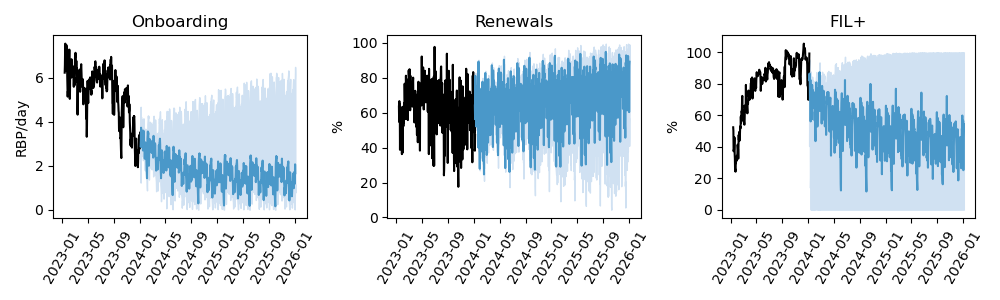

In [13]:
# plot historical trends
t_pred = pd.date_range(historical_rb_date.iloc[-1]+timedelta(days=1), periods=forecast_length, freq='D')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,3), sharex=True)

blues = mpl.colormaps['Blues']
axx = ax[0]
axx.plot(hist_plot_tvec_rbp, hist_rbp, color='k')
# axx.plot(historical_rb_date, historical_rb, color='k')
rbp_quantiles = get_quantiles(rb_onboard_power_pred)
axx.plot(t_pred, rbp_quantiles[1], color=blues(0.6))
axx.fill_between(t_pred, rbp_quantiles[0], rbp_quantiles[2], color=blues(0.2))
axx.set_title('Onboarding')
axx.set_ylabel('RBP/day')
for tick in axx.get_xticklabels(): tick.set_rotation(60)
    
axx = ax[1]
axx.plot(hist_plot_tvec_rr, hist_rr*100, color='k')
# axx.plot(historical_rr_date, historical_rr*100, color='k')
rr_quantiles = get_quantiles(renewal_rate_pred*100)
axx.plot(t_pred, rr_quantiles[1], color=blues(0.6))
axx.fill_between(t_pred, rr_quantiles[0], rr_quantiles[2], color=blues(0.2))
axx.set_title('Renewals')
axx.set_ylabel('%')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

axx = ax[2]
axx.plot(hist_plot_tvec_fpr, hist_fpr*100, color='k')
# axx.plot(historical_fpr_date, historical_fpr*100, color='k')
fpr_quantiles = get_quantiles(filplus_rate_pred*100)
axx.plot(t_pred, fpr_quantiles[1], color=blues(0.6))
axx.fill_between(t_pred, fpr_quantiles[0], fpr_quantiles[2], color=blues(0.2))
axx.set_title('FIL+')
axx.set_ylabel('%')
for tick in axx.get_xticklabels(): tick.set_rotation(60)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'mcmc_inputs.png'))

In [14]:
lock_target = 0.3
sector_duration = 365

simulation_results_vec = []
for ii in tqdm(range(num_samples_mcmc*num_chains_mcmc)):
    rbp_vec = rb_onboard_power_pred[ii,:]
    rr_vec = renewal_rate_pred[ii,:]
    fpr_vec = filplus_rate_pred[ii,:]
    simulation_results = sim.run_sim(
        rbp_vec,
        rr_vec,
        fpr_vec,
        lock_target,
    
        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    simulation_results_vec.append(simulation_results)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [15]:
end_date = current_date + timedelta(forecast_length)
macro_t = du.get_t(start_date, end_date=end_date)

In [16]:
#reconstruct historical power onboarding/pledge/fofr metrics
hist_df = pystarboard.data.get_historical_network_stats(start_date-timedelta(days=360), current_date, end_date)
hist_expire_df = pystarboard.data.query_sector_expirations(start_date-timedelta(days=360), current_date)

In [17]:
hist_df['date'] = pd.to_datetime(hist_df['date'])
hist_df.sort_values('date', inplace=True)
hist_expire_df['date'] = pd.to_datetime(hist_expire_df['date']).dt.tz_localize(None)
hist_expire_df.sort_values('date', inplace=True)
hist_df_merged = pd.merge_asof(hist_df, hist_expire_df, on='date')

# TODO: discuss how to compute this properly from historical data directly ... unsure at the moment
pledge_historical = pd.read_csv('Commit_Pledge_per_32GiB_QAP.csv')
pledge_historical['date'] = pd.to_datetime(pledge_historical['date'])
pledge_historical = pledge_historical[pledge_historical['date'] < pd.to_datetime(current_date)]

hist_df_merged = pd.merge_asof(hist_df_merged, pledge_historical, on='date')

hist_expire_df

In [18]:
# now add the quantities of interest
hist_df_merged['day_network_reward'] = hist_df_merged['mined_fil'].diff()
hist_df_merged['day_network_reward'].iloc[0] = hist_df_merged['day_network_reward'].iloc[1]
hist_df_merged['day_locked_pledge'] = hist_df_merged['locked_fil'].diff()
hist_df_merged['day_renewed_pledge'] = hist_df_merged['extended_pledge'].diff()

hist_df_merged['day_rewards_per_sector'] = C.EIB_PER_SECTOR * hist_df_merged['day_network_reward'] / hist_df_merged['total_qa_power_eib']

/tmp/ipykernel_316984/575488602.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_df_merged['day_network_reward'].iloc[0] = hist_df_merged['day_network_reward'].iloc[1]


In [30]:
hist_plot_tvec = pd.date_range(current_date-timedelta(days=360), current_date, freq='D')

def get_simresults_quantiles(sim_results_vec, key, qvec=[0.25, 0.5, 0.75]):
    key_results = []
    for sr in sim_results_vec:
        key_results.append(np.asarray(sr[key]))  # convert jax to np
    
    return np.nanquantile(np.asarray(key_results), qvec, axis=0)

def plot_mcmc_power_panel(simulation_results_vec):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

    axx = ax[0]
    yy = get_simresults_quantiles(simulation_results_vec, key='rb_total_power_eib')
    axx.plot(hist_df_merged['date'], hist_df_merged['total_raw_power_eib'], color='k')
    axx.plot(macro_t, yy[1], color=blues(0.6))
    axx.fill_between(macro_t, yy[0], yy[2], color=blues(0.2))
    axx.set_ylabel('EiB')
    axx.set_title('RBP')
    # axx.legend(fontsize=8)
    axx.set_ylim(bottom=0)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color='grey', linestyle='--')
    
    axx = ax[1]
    yy = get_simresults_quantiles(simulation_results_vec, key='qa_total_power_eib')
    axx.plot(hist_df_merged['date'], hist_df_merged['total_qa_power_eib'], color='k')
    axx.plot(macro_t, yy[1], color=blues(0.6))
    axx.fill_between(macro_t, yy[0], yy[2], color=blues(0.2))
    baseline = get_simresults_quantiles(simulation_results_vec, key='network_baseline_EIB', qvec=[0.5])
    axx.plot(macro_t, baseline[0], color='k', linestyle='--', label='Baseline')
    axx.set_ylabel('EiB')
    axx.set_title('QAP')
    axx.legend(fontsize=8)
    axx.set_ylim(bottom=0)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color='grey', linestyle='--')
    
    axx = ax[2]
    yy = get_simresults_quantiles(simulation_results_vec, key='day_network_reward')
    axx.plot(hist_df_merged['date'], hist_df_merged['day_network_reward'], color='k')
    axx.plot(macro_t, yy[1], color=blues(0.6))
    axx.fill_between(macro_t, yy[0], yy[2], color=blues(0.2))
    axx.set_ylabel('FIL/day')
    axx.set_title('Minting Rate')
    # axx.legend(fontsize=8)
    axx.set_ylim(bottom=0)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color='grey', linestyle='--')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'mcmc_power.png'))

def plot_supply_panel(simulation_results_vec):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))

    axx = ax[0]
    yy = get_simresults_quantiles(simulation_results_vec, key='network_locked')
    axx.plot(hist_df_merged['date'], hist_df_merged['locked_fil']/1e6, color='k')
    axx.plot(macro_t, yy[1]/1e6, color=blues(0.6))
    axx.fill_between(macro_t, yy[0]/1e6, yy[2]/1e6, color=blues(0.2))
    axx.set_ylabel('M-FIL')
    axx.set_title('Network Locked')
    axx.set_ylim(bottom=0)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color='grey', linestyle='--')
    axx.axhline(100/5, color='red', linestyle='--', alpha=0.5, label='Consensus Security Level \n @$5/FIL')
    axx.legend(fontsize=8, loc='upper right')
    
    axx = ax[1]
    yy = get_simresults_quantiles(simulation_results_vec, key='circ_supply')
    axx.plot(hist_df_merged['date'], hist_df_merged['circulating_fil']/1e6, color='k')
    axx.plot(macro_t, yy[1]/1e6, color=blues(0.6))
    axx.fill_between(macro_t, yy[0]/1e6, yy[2]/1e6, color=blues(0.2))
    axx.set_ylabel('M-FIL')
    axx.set_title('Circulating Supply')
    # axx.legend(fontsize=8)
    axx.set_ylim(bottom=0)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color='grey', linestyle='--')
    
    key_results = []
    for sr in simulation_results_vec:
        key_results.append(np.asarray(sr['network_locked']/sr['circ_supply']))  # convert jax to np
    lcs_q = np.quantile(np.asarray(key_results), [0.25, 0.5, 0.75], axis=0)
    axx = ax[2]
    axx.plot(hist_df_merged['date'], hist_df_merged['locked_fil']/hist_df_merged['circulating_fil']*100, color='k')
    axx.plot(macro_t, lcs_q[1]*100, color=blues(0.6))
    axx.fill_between(macro_t, lcs_q[0]*100, lcs_q[2]*100, color=blues(0.2))
    axx.set_ylabel('%')
    axx.set_title('L/CS')
    axx.set_ylim(bottom=0)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color='grey', linestyle='--')
    axx.axhline(30, color='red', linestyle='--', alpha=0.5, label='Lock Target')
    axx.legend(fontsize=8)
    
    plt.suptitle('Supply Metrics')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'mcmc_supply.png'))

def plot_onboarding_panel(simulation_results_vec):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

    axx = ax[0]
    yy = get_simresults_quantiles(simulation_results_vec, key='day_pledge_per_QAP')
    axx.plot(hist_df_merged['date'], hist_df_merged['pledge'], color='k')
    axx.plot(macro_t, yy[1], color=blues(0.6))
    axx.fill_between(macro_t, yy[0], yy[2], color=blues(0.2))
    axx.set_ylabel('FIL')
    axx.set_title('Pledge/32GiB QA Sector')
    # axx.legend(fontsize=8)
    axx.set_ylim(bottom=0)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color='grey', linestyle='--')
    
    axx = ax[1]
    key_results = []
    for sr in simulation_results_vec:
        # we need to create new time-series and append historical to forecast to compute a smooth FoFR plot
        dpqq_full = np.concatenate([hist_df_merged['pledge'].values, sr['day_pledge_per_QAP']])
        drps_full = np.concatenate([hist_df_merged['day_rewards_per_sector'].values, sr['day_rewards_per_sector']])
        days_1y = 365
        rps_1y = np.convolve(drps_full, np.ones(days_1y), mode='full')[days_1y-1:1-days_1y]
        roi_1y = rps_1y / dpqq_full[:1-days_1y]
        key_results.append(np.asarray(roi_1y*100))

    fofr = np.nanquantile(np.asarray(key_results), [0.25, 0.5, 0.75], axis=0)
    fofr_tvec = pd.date_range(hist_df_merged['date'].iloc[0], periods=len(fofr[0]), freq='D')
    axx.plot(fofr_tvec, fofr[1], color=blues(0.6))
    axx.fill_between(fofr_tvec, fofr[0], fofr[2], color=blues(0.2))
    axx.set_ylabel('%')
    axx.set_title('1Y Realized FoFR')
    axx.set_ylim(bottom=0)
    for tick in axx.get_xticklabels(): tick.set_rotation(60)
    axx.axvline(current_date, color='grey', linestyle='--')
    
    plt.suptitle('Onboarding Metrics')
    plt.tight_layout()

    plt.savefig(os.path.join(save_dir, 'mcmc_onboarding.png'))

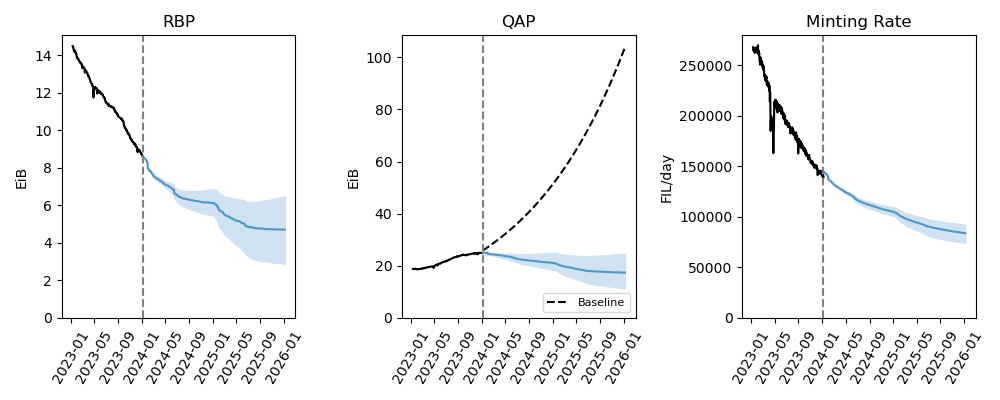

In [31]:
plot_mcmc_power_panel(simulation_results_vec)

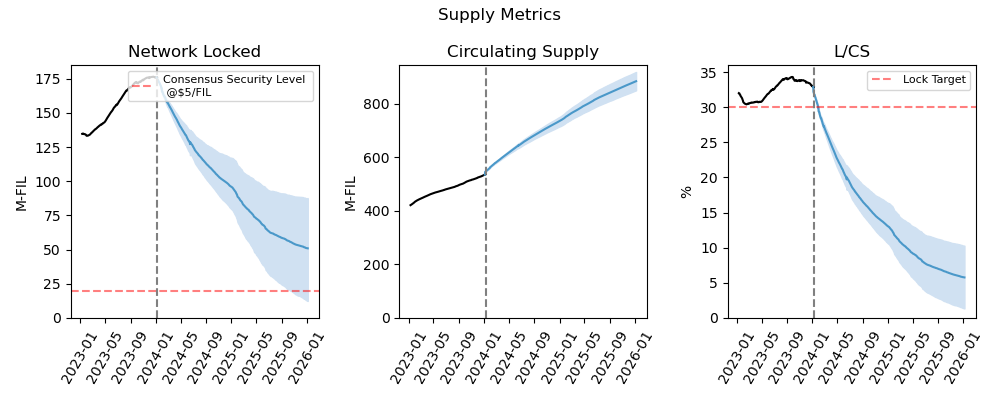

In [32]:
plot_supply_panel(simulation_results_vec)

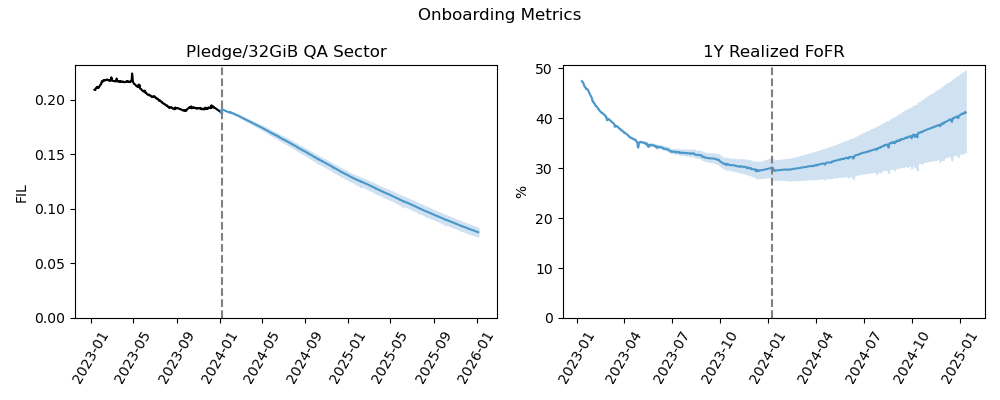

In [26]:
plot_onboarding_panel(simulation_results_vec)

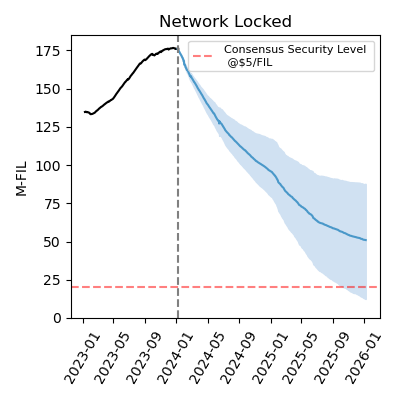

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))

axx = ax
yy = get_simresults_quantiles(simulation_results_vec, key='network_locked')
axx.plot(hist_df_merged['date'], hist_df_merged['locked_fil']/1e6, color='k')
axx.plot(macro_t, yy[1]/1e6, color=blues(0.6))
axx.fill_between(macro_t, yy[0]/1e6, yy[2]/1e6, color=blues(0.2))
axx.set_ylabel('M-FIL')
axx.set_title('Network Locked')
axx.set_ylim(bottom=0)
for tick in axx.get_xticklabels(): tick.set_rotation(60)
axx.axvline(current_date, color='grey', linestyle='--')
axx.axhline(100/5, color='red', linestyle='--', alpha=0.5, label='Consensus Security Level \n @$5/FIL')
axx.legend(fontsize=8, loc='upper right')

plt.tight_layout()

In [67]:
# compute what pledge would be if we implement FIP
gamma = 0.7
new_pledge_vec = []
delta_pledge_vec = []
for ii in range(num_chains_mcmc*num_samples_mcmc):
    onboarded_qap = 0.00003052   # 32 GiB in PiB
    network_qap = simulation_results_vec[ii]['qa_total_power_eib']*1024
    circ_supply = simulation_results_vec[ii]['circ_supply']
    simple_consensus_pledge = lock_target * circ_supply * (onboarded_qap/network_qap)
    baseline_consensus_pledge = simulation_results_vec[ii]['day_pledge_per_QAP']
    new_pledge = simple_consensus_pledge*(1-gamma) + baseline_consensus_pledge*gamma
    new_pledge_vec.append(new_pledge)

    delta_pledge = new_pledge - baseline_consensus_pledge
    delta_pledge_vec.append(delta_pledge)

new_pledge_vec = np.asarray(new_pledge_vec)
delta_pledge_vec = np.asarray(delta_pledge_vec)

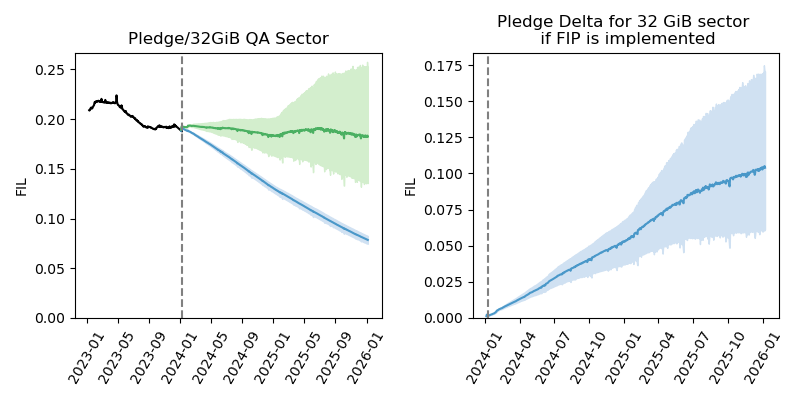

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

axx = ax[0]
yy = get_simresults_quantiles(simulation_results_vec, key='day_pledge_per_QAP')
pledge_new = np.nanquantile(new_pledge_vec, [0.25, 0.5, 0.75], axis=0)
axx.plot(hist_df_merged['date'], hist_df_merged['pledge'], color='k')
axx.plot(macro_t, yy[1], color=blues(0.6))
axx.fill_between(macro_t, yy[0], yy[2], color=blues(0.2))
greens = mpl.colormaps['Greens']
axx.plot(macro_t, pledge_new[1], color=greens(0.6))
axx.fill_between(macro_t, pledge_new[0], pledge_new[2], color=greens(0.2))
axx.set_ylabel('FIL')
axx.set_title('Pledge/32GiB QA Sector')
# axx.legend(fontsize=8)
axx.set_ylim(bottom=0)
for tick in axx.get_xticklabels(): tick.set_rotation(60)
axx.axvline(current_date, color='grey', linestyle='--')

axx = ax[1]
pledge_delta = np.nanquantile(delta_pledge_vec, [0.25, 0.5, 0.75], axis=0)
# axx.plot(hist_df_merged['date'], hist_df_merged['pledge'], color='k')
axx.plot(macro_t, pledge_delta[1], color=blues(0.6))
axx.fill_between(macro_t, pledge_delta[0], pledge_delta[2], color=blues(0.2))
axx.set_ylabel('FIL')
axx.set_title('Pledge Delta for 32 GiB sector \n if FIP is implemented')
# axx.legend(fontsize=8)
axx.set_ylim(bottom=0)
for tick in axx.get_xticklabels(): tick.set_rotation(60)
axx.axvline(current_date, color='grey', linestyle='--')


plt.tight_layout()